In [31]:
import boto3
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from umap import UMAP
from pyqtree import Index
import matplotlib.offsetbox as offsetbox


s3 = boto3.resource('s3')
bucket_name = 'dalle2images'

# Define the image size for the MobileNetV2 model
# image_size = (224, 224)
image_size = (180, 180)
# Define the scale factor and border thickness for displaying the images in the UMAP plot
scale_factor = 0.1
border_thickness = 5




In [54]:
# Load the MobileNetV2 model trained for fake image detection
from huggingface_hub import from_pretrained_keras

# model = from_pretrained_keras("scottlai/monile_v2_fake_image_detection")
model = from_pretrained_keras("poojakabber1997/ResNetDallE2Fakes")
# # Load the image paths from your S3 bucket and select odd-numbered images
# image_paths = []
# for obj in s3.Bucket(bucket_name).objects.all():
#     if obj.key.endswith('.png'):
#         image_num = obj.key.split("/")[-1].split('.')[0]
#         if int(image_num) % 2 == 1:
#             image_paths.append(obj.key)
import random

# Load the image paths from your S3 bucket
image_paths = [obj.key for obj in s3.Bucket(bucket_name).objects.all() if obj.key.endswith('.png')]

real_image_paths = [path for path in image_paths if path.startswith('real')]
fake_image_paths = [path for path in image_paths if path.startswith('fake')]

# Select a random sample of images
n_samples = 200
n_real = n_fake = n_samples // 2

real_samples = random.sample(real_image_paths, n_real)
fake_samples = random.sample(fake_image_paths, n_fake)

image_paths = real_samples + fake_samples
test_labels = [0] * n_real + [1] * n_fake  # Add this line to create the test_labels list

config.json not found in HuggingFace Hub.


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

In [55]:

# Select the first 500 images
image_paths = image_paths[:200]

# Load the selected images from S3 and preprocess them for the MobileNetV2 model
test_images = []
for path in image_paths:
    img_obj = s3.Object(bucket_name, path)
    img = Image.open(img_obj.get()['Body'])
    img = img.resize(image_size, Image.ANTIALIAS)
    img = np.array(img)
    img = img / 255.0
    # img = np.transpose(img, (2, 0, 1))  # Add this line to change the channel order
    test_images.append(img)


test_images = np.stack(test_images)
test_orig_images = (test_images * 255).astype(np.uint8)  # Convert the test_images back to the original format


/var/folders/y2/rmtghvx11dsdnn88ldv2d4w00000gn/T/ipykernel_55831/2692804169.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(image_size, Image.ANTIALIAS)


In [56]:
# Extract the features from the model for UMAP visualization
# Extract the features from the trained model for t-SNE visualization
features = model.predict(test_images)

umap = UMAP(n_components=2, random_state=42)
umap_features = umap.fit_transform(features)
umap_scaling_factor = 30  # Increase this value to increase the distance between points
umap_features = umap_features * umap_scaling_factor
# Plot the results using Matplotlib

7/7 [==============================] - 3s 301ms/step


/var/folders/y2/rmtghvx11dsdnn88ldv2d4w00000gn/T/ipykernel_55831/3005980892.py:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_resized = Image.fromarray(img).resize((int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), Image.ANTIALIAS)


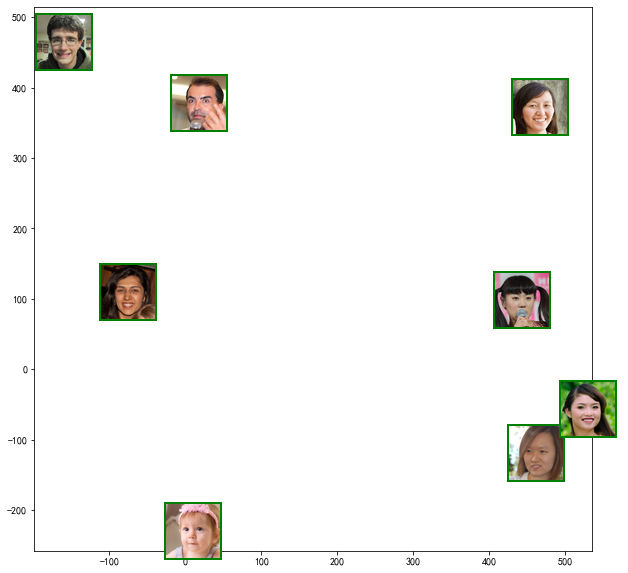

In [63]:
# Define the scale factor and border thickness for displaying the images in the UMAP plot
scale_factor = 0.3
border_thickness = 2


fig, ax = plt.subplots(figsize=(10, 10))

# Initialize the QuadTree with a bounding box covering the entire UMAP features range
bbox = (umap_features[:, 0].min(), umap_features[:, 1].min(), umap_features[:, 0].max(), umap_features[:, 1].max())
quadtree = Index(bbox)

# Add a padding factor to increase the space between images
padding_factor = 1.2

# Loop through the UMAP features
for i, (x, y) in enumerate(umap_features):
    img = test_orig_images[i]

    # Transpose the image back to the original channel order
    # img = np.transpose(img, (1, 2, 0))

    # Resize the image
    img_resized = Image.fromarray(img).resize((int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), Image.ANTIALIAS)
    border_color = 'red' if test_labels[i] == 1 else 'green'
    bordered_image = Image.new('RGB', (img_resized.width + 2 * border_thickness, img_resized.height + 2 * border_thickness), border_color)
    bordered_image.paste(img_resized, (border_thickness, border_thickness))


    # Create the bounding box for the image and check for collisions in the QuadTree
    half_width = img_resized.width / 2 * padding_factor
    half_height = img_resized.height / 2 * padding_factor
    image_bbox = (x - half_width, y - half_height, x + half_width, y + half_height)

    # If there are no collisions, insert the image into the QuadTree and add the image to the plot
    if not quadtree.intersect(image_bbox):
        quadtree.insert(item=i, bbox=image_bbox)
        imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(bordered_image), (x, y), frameon=False)
        ax.add_artist(imagebox)

# Set the plot limits and display the plot
ax.set_xlim(umap_features[:, 0].min() - 5, umap_features[:, 0].max() + 5)
ax.set_ylim(umap_features[:, 1].min() - 5, umap_features[:, 1].max() + 5)
plt.show()

/var/folders/y2/rmtghvx11dsdnn88ldv2d4w00000gn/T/ipykernel_55831/3156713545.py:46: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_resized = Image.fromarray(img).resize((int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), Image.ANTIALIAS)


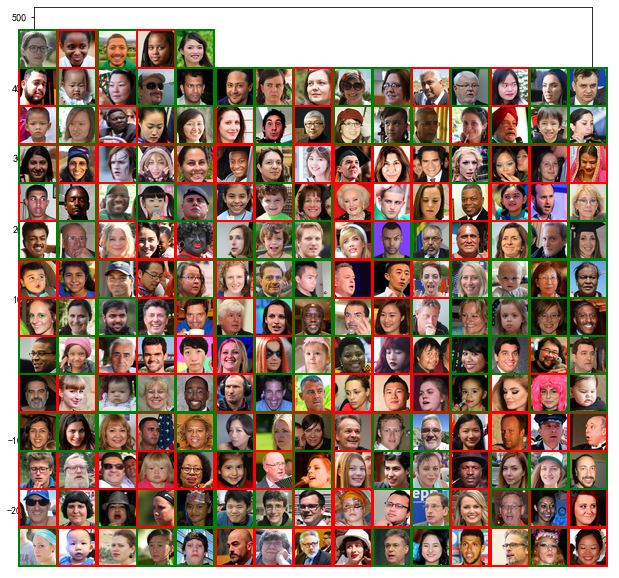

In [61]:
import numpy as np
from pyqtree import Index
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
import numpy as np
from pyqtree import Index

fig, ax = plt.subplots(figsize=(10, 10))

# Define the scale factor and border thickness for displaying the images in the UMAP plot
scale_factor = 0.2
border_thickness = 2
# Sort the images by their UMAP coordinates
sorted_indices = np.lexsort((umap_features[:, 1], umap_features[:, 0]))

# Calculate the number of rows and columns for the grid
n_rows = int(np.ceil(np.sqrt(len(umap_features))))
n_columns = n_rows

# Calculate the range of x and y coordinates
x_range = umap_features[:, 0].max() - umap_features[:, 0].min()
y_range = umap_features[:, 1].max() - umap_features[:, 1].min()

# Calculate the spacing between images in the grid
x_spacing = x_range / (n_columns - 1)
y_spacing = y_range / (n_rows - 1)

# Initialize the grid
grid = np.zeros((n_rows, n_columns))

# Loop through the sorted images and place them in the grid
for i, index in enumerate(sorted_indices):
    row = i // n_columns
    column = i % n_columns

    # Calculate the x and y coordinates for the current image
    x = umap_features[:, 0].min() + column * x_spacing
    y = umap_features[:, 1].min() + row * y_spacing

    # Load and resize the image
    img = test_orig_images[index]

    # Transpose the image back to the original channel order
    # img = np.transpose(img, (1, 2, 0))

    img_resized = Image.fromarray(img).resize((int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), Image.ANTIALIAS)
    border_color = 'red' if test_labels[index] == 1 else 'green'
    bordered_image = Image.new('RGB', (img_resized.width + 2 * border_thickness, img_resized.height + 2 * border_thickness), border_color)
    bordered_image.paste(img_resized, (border_thickness, border_thickness))

    # Add the image to the plot
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(bordered_image), (x, y), frameon=False)
    ax.add_artist(imagebox)

# Set the plot limits and display the plot
ax.set_xlim(umap_features[:, 0].min() - 5, umap_features[:, 0].max() + 5)
ax.set_ylim(umap_features[:, 1].min() - 5, umap_features[:, 1].max() + 5)
plt.show()
